In [307]:
import re
import warnings

import pandas as pd
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category = SettingWithCopyWarning)

from ltrcart import LTRCart
from survival_data import SurvivalData
import sys
from lifelines import CoxPHFitter
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import graphviz 
from sklearn import tree

from matplotlib import pyplot as plt
from joblib import Parallel, delayed

import numpy as np
from sksurv.datasets import load_gbsg2
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import integrated_brier_score 
from scipy.stats import weibull_min

# Testing the LTRCart Tree class on some Real LTRC data

In [14]:
train = pd.read_csv("~/PycharmProjects/LTRCSurvivalTree/sample_data/creatinine_train.csv",index_col=0)
test = pd.read_csv("~/PycharmProjects/LTRCSurvivalTree/sample_data/creatinine_test.csv",index_col=0)

In [15]:
train.head()

,age,sex,sample.yr,kappa,lambda,FLC,creatinine,mgus,futime,death,chapter,End
1,97,F,1997,5.70,4.860,10,1.7,0,85,1,Circulatory,97.232877
2,92,F,2000,0.87,0.683,1,0.9,0,1281,1,Neoplasms,95.509589
3,94,F,1997,4.36,3.850,10,1.4,0,69,1,Circulatory,94.189041
4,92,F,1996,2.42,2.220,9,1.0,0,115,1,Circulatory,92.315068
5,93,F,1996,1.32,1.690,6,1.1,0,1039,1,Circulatory,95.846575


In [16]:
y_train = SurvivalData(train[['age','End','death']])
y_test = SurvivalData(test[['age','End','death']])

In [17]:
x_train = train.loc[:,['sex' , 'FLC' , 'creatinine']]
x_test = test.loc[:,['sex' , 'FLC' , 'creatinine']]

x_train = x_train.replace({'F':0,'M':1})
x_test = x_test.replace({'F':0,'M':1})

[Text(0.5555555555555556, 0.875, 'FLC <= 9.5\npoisson = 0.278\nsamples = 500\nvalue = 0.572'),
 Text(0.3333333333333333, 0.625, 'creatinine <= 1.25\npoisson = 0.275\nsamples = 334\nvalue = 0.668'),
 Text(0.2222222222222222, 0.375, 'FLC <= 2.5\npoisson = 0.285\nsamples = 248\nvalue = 0.738'),
 Text(0.1111111111111111, 0.125, 'poisson = 0.319\nsamples = 28\nvalue = 1.097'),
 Text(0.3333333333333333, 0.125, 'poisson = 0.269\nsamples = 220\nvalue = 0.692'),
 Text(0.4444444444444444, 0.375, 'poisson = 0.201\nsamples = 86\nvalue = 0.467'),
 Text(0.7777777777777778, 0.625, 'creatinine <= 1.95\npoisson = 0.231\nsamples = 166\nvalue = 0.379'),
 Text(0.6666666666666666, 0.375, 'poisson = 0.237\nsamples = 144\nvalue = 0.414'),
 Text(0.8888888888888888, 0.375, 'poisson = 0.097\nsamples = 22\nvalue = 0.15')]

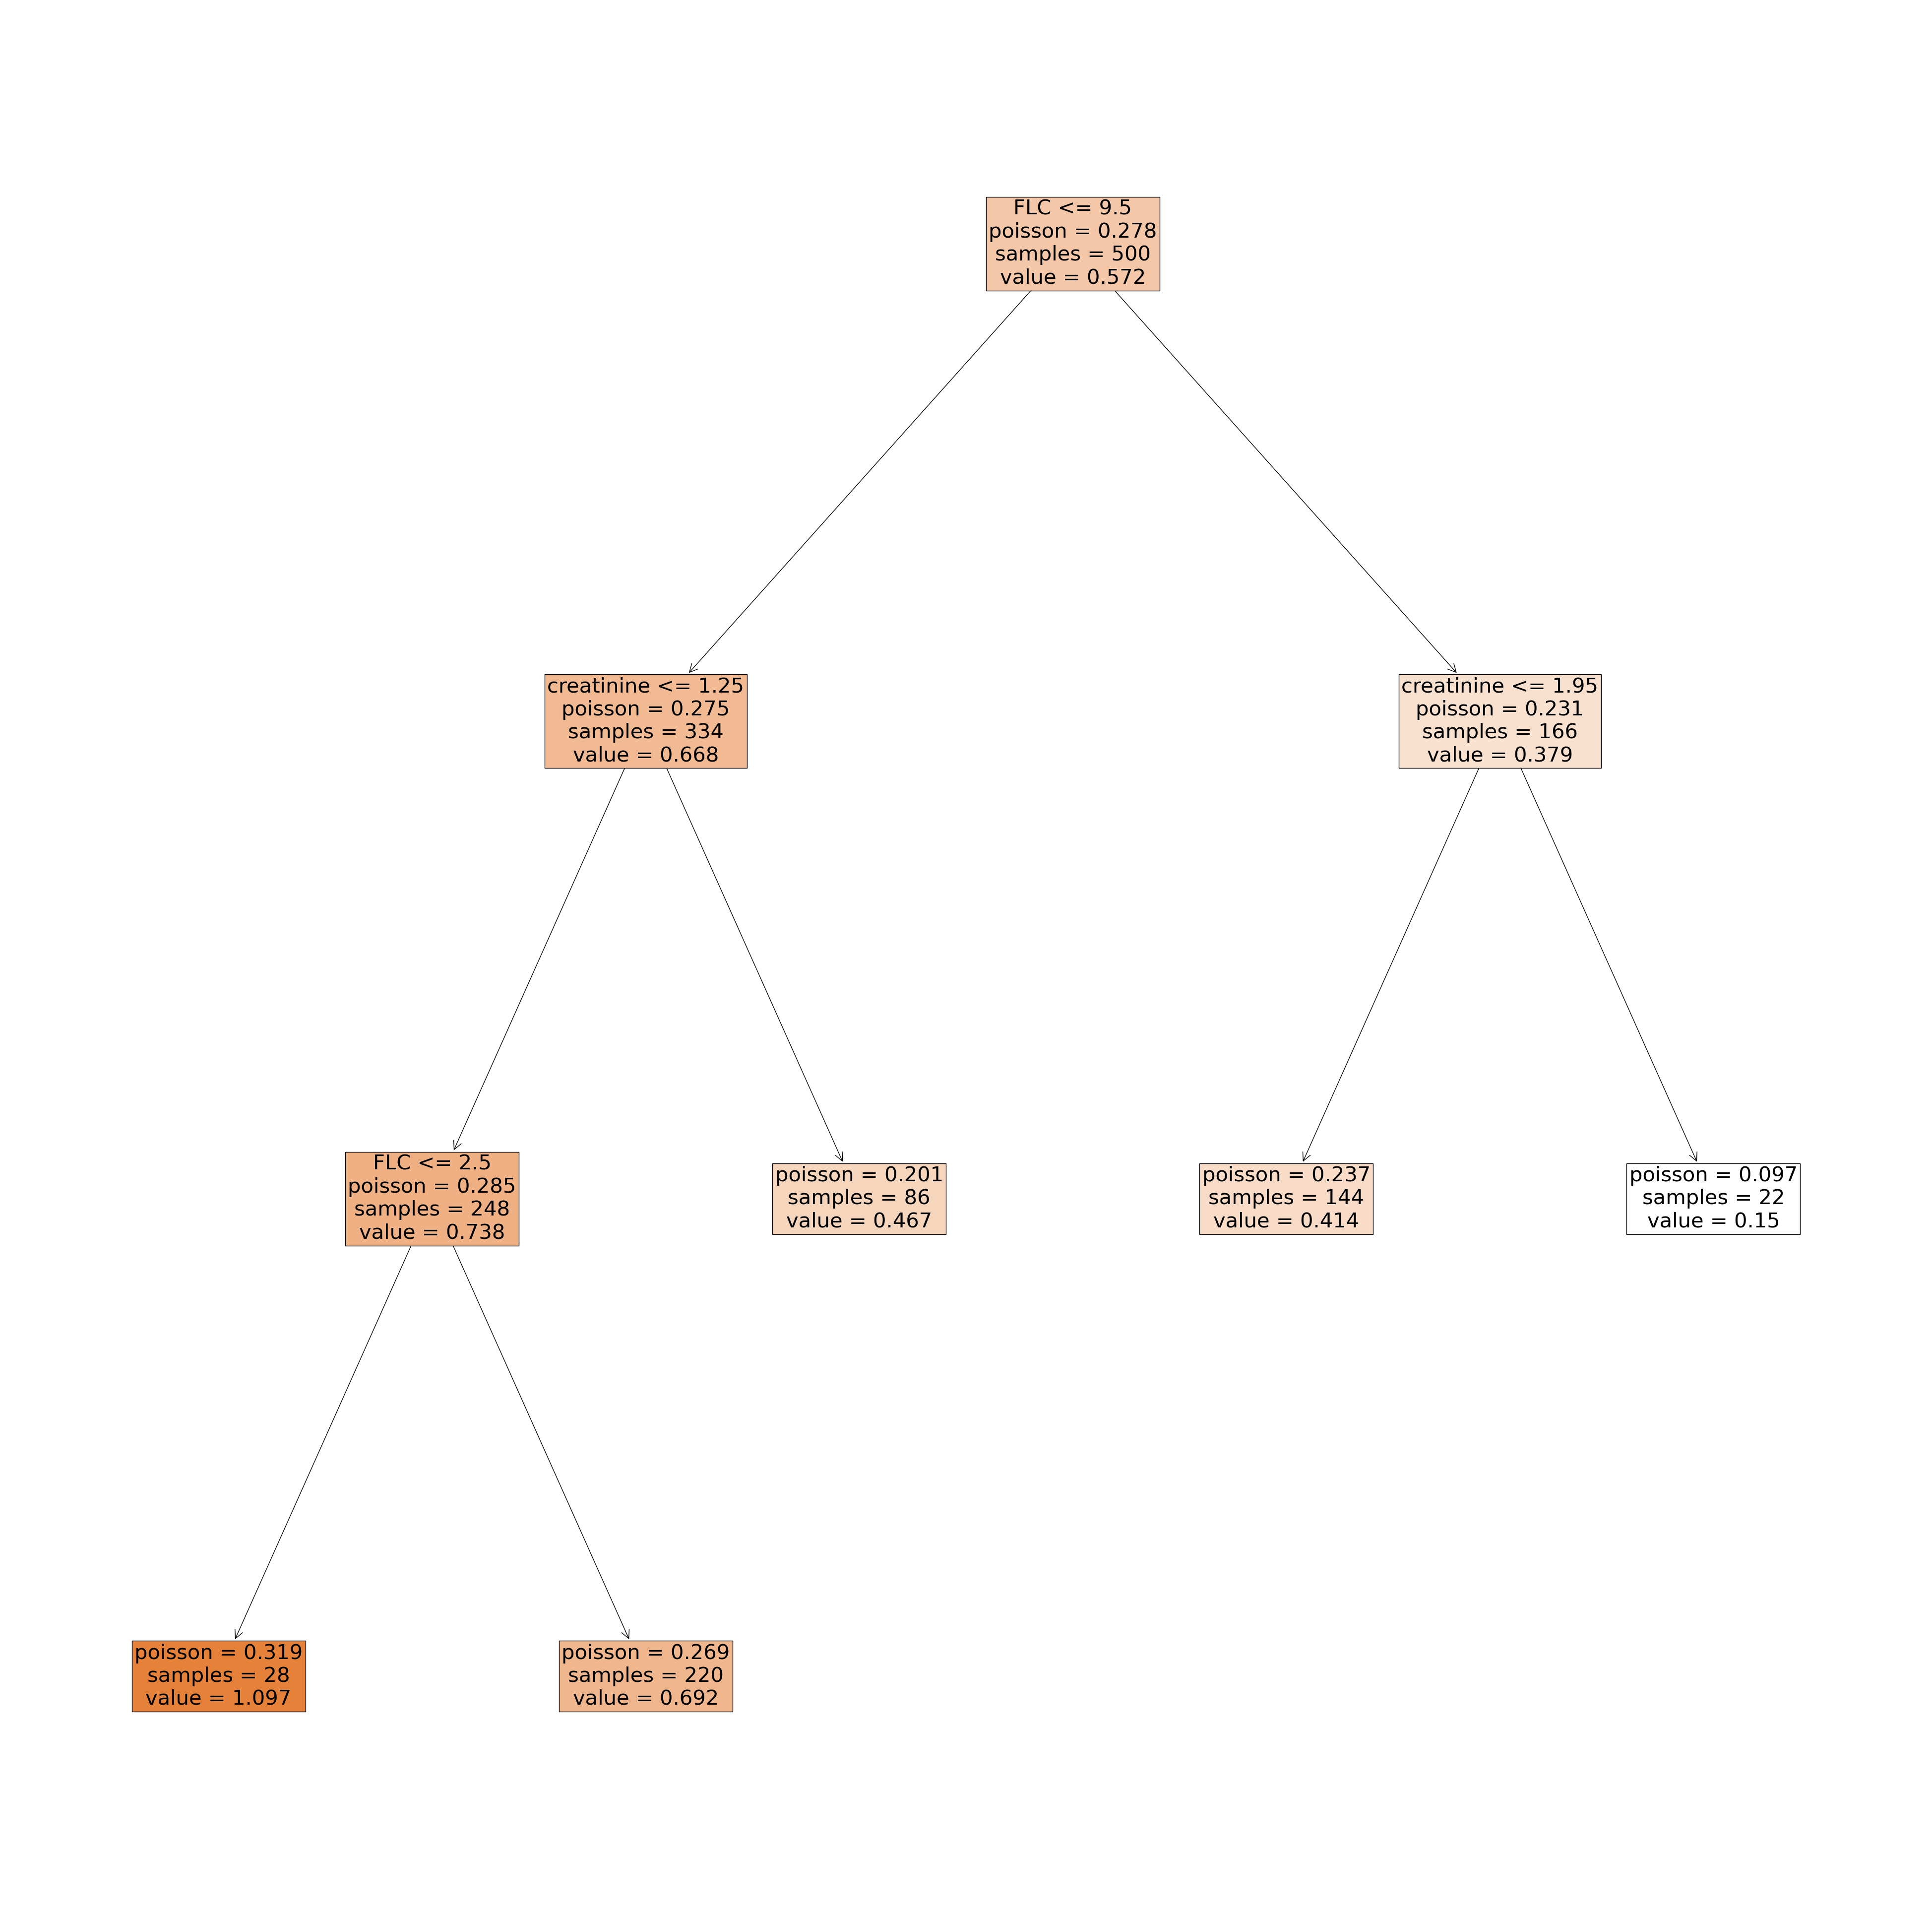

In [ ]:
ltrc_art_obj =  LTRCart(y_train,x_train)
ltrc_cart_tree = ltrc_art_obj.ltrc_art_fit()
fig = plt.figure(figsize=(50,50))
tree.plot_tree(ltrc_cart_tree,fontsize=30,feature_names=x_train.columns,filled = True)

# Simulated data test

## Exponential simulated events

In [337]:
from scipy.stats.sampling import NumericalInverseHermite
from scipy.special import ndtr
from scipy.stats import norm
class bathtub:
    def pdf(self, t):
        return ((0.01*t**2*np.exp(-0.5*0.01*t**2)+5*np.exp(-0.5*0.01*t**2))/
                   ((1+5*t)**2))
    def cdf(self, x):
        return ndtr(x)

dist = bathtub()
urng = np.random.default_rng()
rng = NumericalInverseHermite(dist, order=5, random_state=urng)


/var/folders/_1/cmv1tscx3xd4t6w2kzm60s580000gn/T/ipykernel_45259/3013635343.py:13: RuntimeWarning: [objid: HINV] 22 : dPDF => (distribution) incomplete distribution object, entry missing
  rng = NumericalInverseHermite(dist, order=5, random_state=urng)


UNURANError: [objid: HINV] 51 : too many intervals => (generator) condition for method violated

### simulated data function

In [339]:
class SimDataPrep():

    def __init__(self,lt, heavy, n_obs,
                 proper_values = ['<= 2.5', '<= 1.5', '>  1.5', '>  2.5'],
                 proper_features = ['feature_0', 'feature_1', 'feature_1', 'feature_0', 'feature_2', 'feature_2']):
        self.proper_values = proper_values
        self.proper_features = proper_features
        self.lt = lt
        self.heavy = heavy
        self.n_obs = n_obs
        
    def create_sim_data_exp(self, dist_values=[1/0.1,1/0.23,1/0.4,1/0.9])->(pd.DataFrame, pd.DataFrame):
        """
        Creates exp simulated data
        """
        sim_data = self.sim_data()

        t_1=np.random.exponential(dist_values[0],5000)*((sim_data.x_1<=2) & (sim_data.x_2<=1))
        t_2=np.random.exponential(dist_values[1],5000)*((sim_data.x_1<=2) & (sim_data.x_2>1))
        t_3=np.random.exponential(dist_values[2],5000)*((sim_data.x_1>2) & (sim_data.x_3<=1))
        t_4=np.random.exponential(dist_values[3],5000)*((sim_data.x_1>2) & (sim_data.x_3>1))

        sim_data['t'] = pd.DataFrame([t_1,t_2,t_3,t_4]).max()

        return self.censoring(sim_data)
    
    def create_sim_data_weibull(self, shape = 0.9, dist_values = [7,3,2.5,1])->(pd.DataFrame, pd.DataFrame):
        """
        Creates Weibull simulated data
        """
        sim_data = self.sim_data()

        t_1 = weibull_min.rvs(shape, 0, dist_values[0], size=5000) * ((sim_data.x_1<=2) & (sim_data.x_2<=1))
        t_2 = weibull_min.rvs(shape, 0, dist_values[1], size=5000) * ((sim_data.x_1<=2) & (sim_data.x_2>1))
        t_3 = weibull_min.rvs(shape, 0, dist_values[2], size=5000) * ((sim_data.x_1>2) & (sim_data.x_3<=1))
        t_4 = weibull_min.rvs(shape, 0, dist_values[3], size=5000) * ((sim_data.x_1>2) & (sim_data.x_3>1))

        sim_data.loc[:, 't'] = pd.DataFrame([t_1,t_2,t_3,t_4]).max()
        
        return self.censoring(sim_data)
    
    
    def create_sim_data_log_normal(self, mean = [2, 1.7, 1.3, 0.5], sigma = [0.3, 0.2, 0.3, 0.5])->(pd.DataFrame, pd.DataFrame):
        """
        Creates lognormal simulated data
        """
        sim_data = self.sim_data()

        t_1 = np.random.lognormal(mean[0], sigma[0], size=5000) * ((sim_data.x_1<=2) & (sim_data.x_2<=1))
        t_2 = np.random.lognormal(mean[1], sigma[1], size=5000) * ((sim_data.x_1<=2) & (sim_data.x_2>1))
        t_3 = np.random.lognormal(mean[2], sigma[2], size=5000) * ((sim_data.x_1>2) & (sim_data.x_3<=1))
        t_4 = np.random.lognormal(mean[3], sigma[3], size=5000) * ((sim_data.x_1>2) & (sim_data.x_3>1))

        sim_data.loc[:, 't'] = pd.DataFrame([t_1,t_2,t_3,t_4]).max()
        
        return self.censoring(sim_data)
    
    def create_sim_data_bathtub(self, a = [0.01, 0.05, 0.1, 0.7])->(pd.DataFrame, pd.DataFrame):
        """
        Creates bathtub simulated data
        """
        sim_data = self.sim_data()
        def bathtub_aux(a_i):
            t = np.random.rand(5000)
            bathtub_surv_function = (np.exp(-0.5*a_i*(t**2)))/((1+c*t)**(b/c))
            
        t_1 = bathtub_aux(a[0]) * ((sim_data.x_1<=2) & (sim_data.x_2<=1))
        t_2 = bathtub_aux(a[1]) * ((sim_data.x_1<=2) & (sim_data.x_2>1))
        t_3 = bathtub_aux(a[2]) * ((sim_data.x_1>2) & (sim_data.x_3<=1))
        t_4 = bathtub_aux(a[3]) * ((sim_data.x_1>2) & (sim_data.x_3>1))

        sim_data.loc[:, 't'] = pd.DataFrame([t_1,t_2,t_3,t_4]).max()
        
        return self.censoring(sim_data)
    
    
    def tree_reconstruction(self, y_s, x_s):
        surv_data = SurvivalData(y_s)
        ltrc_art_tree = LTRCart(surv_data,x_s, control = {"max_depth":30, "min_samples_split":20, "min_samples_leaf":round(20/3)})
        ltrc_art_tree = ltrc_art_tree.ltrc_art_fit()
        tree_as_text = tree.export_text(ltrc_art_tree,max_depth=1)
        tree_features = re.findall('feature_*\\S',tree_as_text)
        tree_values = re.findall('<= [0-9].[0-9]|>  [0-9].[0-9]',tree_as_text)[0:4]
        if ((tree_features == self.proper_features) & (tree_values == self.proper_values)):
            return True
        return False
    
    def trs_exp(self, i):
        y_s,x_s = self.create_sim_data_exp()
        return self.tree_reconstruction(y_s, x_s)
    
    def trs_weibull_i(self, i):
        y_s,x_s = self.create_sim_data_weibull()
        return self.tree_reconstruction(y_s, x_s)
    
    def trs_weibull_d(self, i):
        y_s,x_s = self.create_sim_data_weibull(shape = 3, dist_values = [2.0, 4.3, 6.2, 10.0])
        return self.tree_reconstruction(y_s, x_s)
    
    
    def trs_log_normal(self,i):
        y_s,x_s = self.create_sim_data_log_normal()
        return self.tree_reconstruction(y_s, x_s)

    def censoring(self, sim_data) -> pd.DataFrame:
        
        sim_data = sim_data.loc[sim_data['t'] >= sim_data['lt']]
        prop_cens = 0
        c = 16
        min_cens = 0.5 if self.heavy else 0.2
        while prop_cens <= min_cens:
            sim_data['c'] = sim_data['lt'] + np.random.exponential(scale = c,size = sim_data.shape[0])
            prop_cens = ((sim_data.c < sim_data.t).sum() / sim_data.shape[0])
            c -= 0.02
        sim_data['event'] = (sim_data.c >= sim_data.t.astype(int))
        sim_data['t'] = sim_data[['t','c']].min(axis = 1)
        return (sim_data.iloc[:self.n_obs][['lt', 't', 'event']],
                sim_data.iloc[:self.n_obs][['x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6']])

    def sim_data(self) -> pd.DataFrame:
        x_1, x_4 = np.random.randint(1,6,5000), np.random.randint(1,6,5000)
        x_2, x_5 = np.random.randint(1,3,5000), np.random.randint(1,3,5000)
        x_3, x_6 = np.random.rand(5000) * 2, np.random.rand(5000) * 2
        sim_data = pd.DataFrame({'x_1':x_1,'x_2':x_2,'x_3':x_3,'x_4':x_4,'x_5':x_5,'x_6':x_6})

        sim_data['lt'] = np.random.rand(5000) * self.lt
        return sim_data

### The actual tree constraction

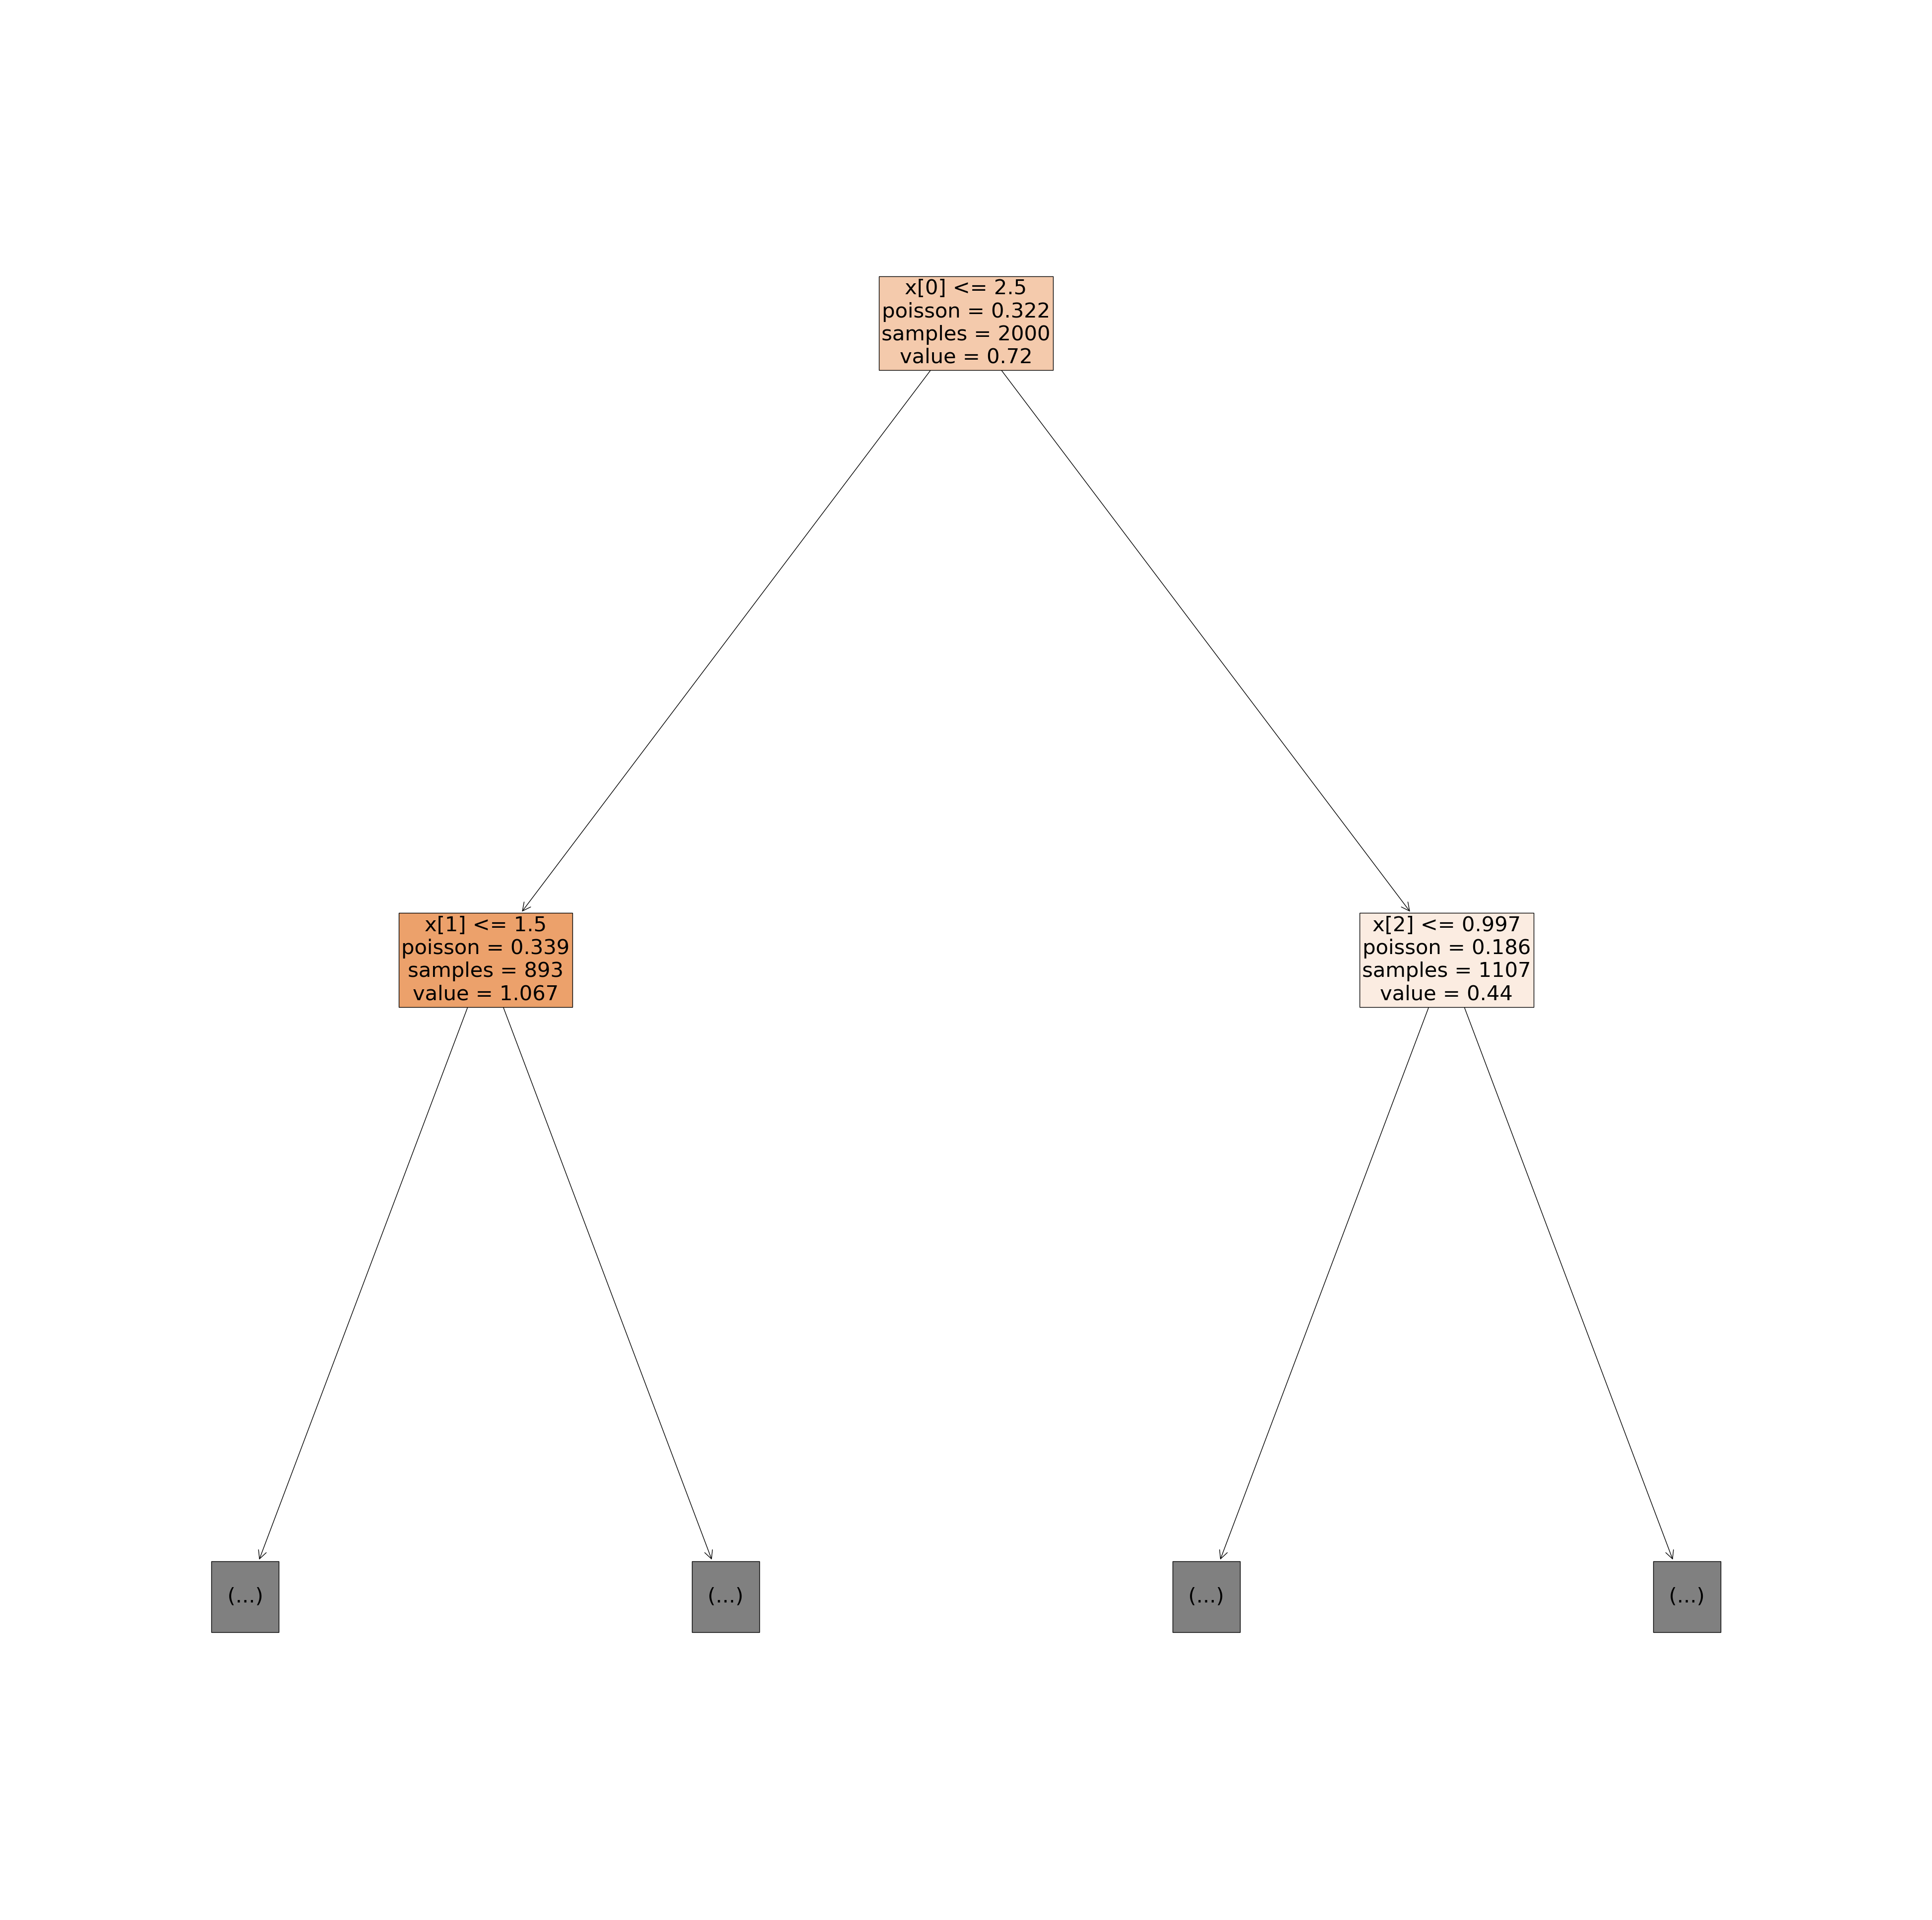

In [241]:
sdp = SimDataPrep(heavy=False, n_obs=2000, lt=1)
y_light_s,x_light_s = sdp.create_sim_data_exp()
surv_data = SurvivalData(y_light_s)
ltrc_art_tree =LTRCart(surv_data,x_light_s, control = {"max_depth":30, "min_samples_split":20, "min_samples_leaf":round(20/3)})
ltrc_art_tree = ltrc_art_tree.ltrc_art_fit()
fig = plt.figure(figsize=(50,50))
plot_tree = tree.plot_tree(ltrc_art_tree,fontsize=30,filled = True,max_depth=1)

### Simulation for all different exp parameters 
- Heavy/Light censoring
- Sample size for training
- Left Truncation distribution ($U[0,1], U[0,2], U[0,3]$)

In [ ]:
results_df = pd.DataFrame({'heavy':[True,True,True,False,False,False]*3,
                               'n_obs':[100,100,100,300,300,300,500,500,500]*2, 
                               'lt':[1,2,3]*6, 'res':[0]*18})
results_df = results_df.set_index(['heavy','n_obs','lt'])

results_df_exp = results_df.copy()
results_df_exp['type'] = 'exp'

results_df_weibull_i = results_df.copy()
results_df_weibull_i['type'] = 'Weibull-I'

results_df_weibull_d = results_df.copy()
results_df_weibull_d['type'] = 'Weibull-D'

results_df_log_normal = results_df.copy()
results_df_log_normal['type'] = 'log normal'

for heavy_param in (True,False):
    for n_obs_param in (100, 300, 500):
        for lt_param in (1,2,3):
            sdp = SimDataPrep(heavy = heavy_param, n_obs = n_obs_param, lt = lt_param, proper_features = proper_features,
                              proper_values = proper_values)
            
            results_exp = np.mean(Parallel(n_jobs=3)(delayed(sdp.trs_exp)(i) for i in range(1000)))
            results_df_exp.loc[(heavy_param,n_obs_param,lt_param), 'res'] = results_exp
            
            results_weibull_i = np.mean(Parallel(n_jobs=3)(delayed(sdp.trs_weibull_i)(i) for i in range(1000)))
            results_df_weibull_i.loc[(heavy_param, n_obs_param, lt_param), 'res'] = results_weibull_i
            
            results_weibull_d = np.mean(Parallel(n_jobs=3)(delayed(sdp.trs_weibull_d)(i) for i in range(1000)))
            results_df_weibull_d.loc[(heavy_param, n_obs_param, lt_param), 'res'] = results_weibull_d
            
            log_normal_res = np.mean(Parallel(n_jobs=3)(delayed(sdp.trs_log_normal)(i) for i in range(1000)))
            results_df_log_normal.loc[(heavy_param, n_obs_param, lt_param), 'res'] = log_normal_res
main_res_df = pd.concat([results_df_exp, results_df_weibull_i, results_df_weibull_d, results_df_log_normal])
main_res_df = main_res_df.set_index('type',append=True).unstack().droplevel(0,axis=1)

/var/folders/_1/cmv1tscx3xd4t6w2kzm60s580000gn/T/ipykernel_45259/2047873700.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/_1/cmv1tscx3xd4t6w2kzm60s580000gn/T/ipykernel_45259/2047873700.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/_1/cmv1tscx3xd4t6w2kzm60s580000gn/T/ipykernel_45259/2047873700.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

In [342]:
main_res_df*100

type            Weibull-D  Weibull-I   exp  log normal
heavy n_obs lt                                        
False 100   1        80.0        0.0  20.0        20.0
            2        40.0        0.0   0.0        20.0
            3        40.0       20.0   0.0        60.0
      300   1       100.0       20.0  40.0        40.0
            2        80.0       60.0  60.0        60.0
            3        40.0       40.0  60.0        80.0
      500   1       100.0       80.0  60.0       100.0
            2        60.0       60.0  80.0        80.0
            3        80.0       60.0  60.0       100.0
True  100   1         0.0        0.0   0.0         0.0
            2        20.0        0.0   0.0         0.0
            3        20.0        0.0   0.0        20.0
      300   1        20.0        0.0   0.0        40.0
            2        20.0       20.0  20.0         0.0
            3        60.0        0.0   0.0         0.0
      500   1        60.0        0.0  20.0        20.0
            2        80.0       40.0   0.0        20.0
            3        80.0       20.0  20.0         0.0

In [322]:
tmp = pd.concat([results_df_weibull_d,results_df_weibull_i])

In [324]:
tmp.set_index('type',append=True).unstack()

res          
type           Weibull-D Weibull-I
heavy n_obs lt                    
False 100   1        0.8       0.0
            2        0.6       0.0
            3        0.8       0.0
      300   1        0.6       0.4
            2        0.6       0.4
            3        0.8       0.8
      500   1        0.8       0.6
            2        1.0       1.0
            3        0.4       1.0
True  100   1        0.2       0.0
            2        0.2       0.0
            3        0.0       0.0
      300   1        0.6       0.0
            2        0.2       0.0
            3        0.4       0.0
      500   1        0.6       0.0
            2        0.8       0.4
            3        1.0       0.0

In [214]:
heavy_param = False
n_obs_param = 500
lt_param = 1
def trs_weibull_i(i):
    sdp = SimDataPrep(heavy = heavy_param, n_obs = n_obs_param, lt = lt_param)
    y_s,x_s = sdp.create_sim_data_weibull()
    return sdp.tree_reconstruction(y_s, x_s)
            
results_weibull_i = np.mean(Parallel(n_jobs=4)(delayed(trs_weibull_i)(i) for i in range(1000)))


In [215]:
results_weibull_i

0.674

In [ ]:
results_df_weibull_i = pd.DataFrame({'heavy':[True,True,True,False,False,False] * 3,
                               'n_obs':[100,100,100,300,300,300,500,500,500] * 2, 
                               'lt':[1,2,3]*6, 'res':[0]*18})
results_df_weibull_i = results_df_weibull_i.set_index(['heavy','n_obs','lt'])
for heavy_param in (True,False):
    for n_obs_param in (100, 300, 500):
        for lt_param in (1,2,3):
            
            def trs_weibull_i(i):
                sdp = SimDataPrep(heavy = heavy_param, n_obs = n_obs_param, lt = lt_param)
                y_s,x_s = sdp.create_sim_data_weibull()
                return sdp.tree_reconstruction(y_s, x_s)
            
            results_weibull_i = np.mean(Parallel(n_jobs=4)(delayed(trs_weibull_i)(i) for i in range(1000)))
            results_df_weibull_i.loc[(heavy_param,n_obs_param,lt_param)] = results_weibull_i

### Simulation Results

In [155]:
results_df_exp

res
heavy n_obs lt       
True  100   1   0.030
            2   0.023
            3   0.014
False 300   1   0.440
            2   0.459
            3   0.429
True  500   1   0.170
            2   0.187
            3   0.235
False 100   1   0.218
            2   0.158
            3   0.142
True  300   1   0.058
            2   0.072
            3   0.070
False 500   1   0.663
            2   0.693
            3   0.674

# Brier score

In [21]:
y, X = create_sim_data()
new_y = y[['event','t']].to_numpy()
#List of tuples
aux = [(e1,e2) for e1,e2 in new_y]

#Structured array
new_y= np.array(aux, dtype=[('Status', '?'), ('Survival_in_days', '<f8')])

est = CoxPHSurvivalAnalysis(ties="efron").fit(X, new_y)
survs = est.predict_survival_function(X)
times = y.t.loc[:300]
preds = np.asarray([[fn(t) for t in times] for fn in survs])
score = integrated_brier_score(new_y, new_y, preds, times)
print(score)

0.34775928208692947


In [ ]:
def cox_ibs(y,X):

    # y, X = y.iloc[:300], X.iloc[:300]
    new_y = y[['event','t']].to_numpy()
    #List of tuples
    aux = [(e1,e2) for e1,e2 in new_y]

    #Structured array
    new_y= np.array(aux, dtype=[('Status', '?'), ('Survival_in_days', '<f8')])

    est_5 = CoxPHSurvivalAnalysis(ties="efron").fit(X, new_y)
    survs_5 = est.predict_survival_function(X)
    est_6 = CoxPHFitter(penalizer=0).fit(df=y, duration_col='t', event_col='event', entry_col='lt')
    survs_6 = est_6.predict_survival_function(X)
    times = y.loc[((y.event==1) & (y.t<y.t.max())),'t']
    
    preds_5 = np.asarray([[fn(t) for t in times] for fn in survs_5])
    preds_6 = np.asarray([[fn[t] for t in times] for fn in survs_6])

    score_5 = integrated_brier_score(new_y, new_y, pred_5, times)
    score_6 = integrated_brier_score(new_y, new_y, preds_6, times)
    return score_5,score_6

In [12]:
y, X = create_sim_data()

array([[0.51205026, 0.96379513, 0.6434624 , ..., 0.6391052 , 0.86981203,
        0.29194785],
       [0.20873639, 0.91730468, 0.35630089, ..., 0.35067921, 0.72146486,
        0.05603493],
       [0.5185048 , 0.96446051, 0.64879373, ..., 0.64448238, 0.87208549,
        0.29875284],
       ...,
       [0.23013172, 0.92224949, 0.37995455, ..., 0.37433028, 0.73628532,
        0.06705175],
       [0.39575202, 0.9502114 , 0.54302671, ..., 0.5379409 , 0.82434583,
        0.18175827],
       [0.3777275 , 0.94777418, 0.5266063 , ..., 0.52142748, 0.81637709,
        0.16682306]])

In [13]:
ibs = []
for i in range(1):
    y_i = y.sample(300)
    x_i = X.loc[y_i.index]
    avg = cox_ibs(y_i,x_i)
    ibs.append(avg)

0      4.948606
1      0.614461
2      3.232760
3      1.508312
4      1.156386
         ...   
295    5.021628
296    4.040801
298    3.283915
299    1.265601
300    9.596900
Name: t, Length: 252, dtype: float64

In [ ]:

# Import libraries
import matplotlib.pyplot as plt
import numpy as np
 
 
# Creating dataset
np.random.seed(10)
data = np.random.normal(100, 20, 200)
 
fig = plt.figure(figsize =(10, 7))
 
# Creating plot
plt.boxplot(ibs)
 
# show plot
plt.show()